In [1]:
import numpy as np
from matplotlib import pyplot as pl

from mlp_backprop_momentum import MLP
import k_fold_cross_validation as cv

import scipy.io.wavfile as wav
from scikits.talkbox.features import mfcc

from MFCC_computation import *

%matplotlib inline

In [2]:
import glob
import os

path = os.getcwd() + '/vowels'

VOWELS = glob.glob(path + '/*.wav')
assert len(VOWELS) > 0, ".wav files not found in " + path + " ! Please check the path"

FILES = {
    'natural_male': glob.glob(path + '/nam*.wav'),
    'natural_female': glob.glob(path + '/naf*.wav'),
    'natural_kid': glob.glob(path + '/nk*.wav'),
    # 'synth_male': glob.glob(path + '/sam*.wav'),
    #'synth_female': glob.glob(path + '/saf*.wav'),
    #'synth_kid': glob.glob(path + '/sk*.wav')
}

MFCC_COEFFS = 5

### MFCC Visualization

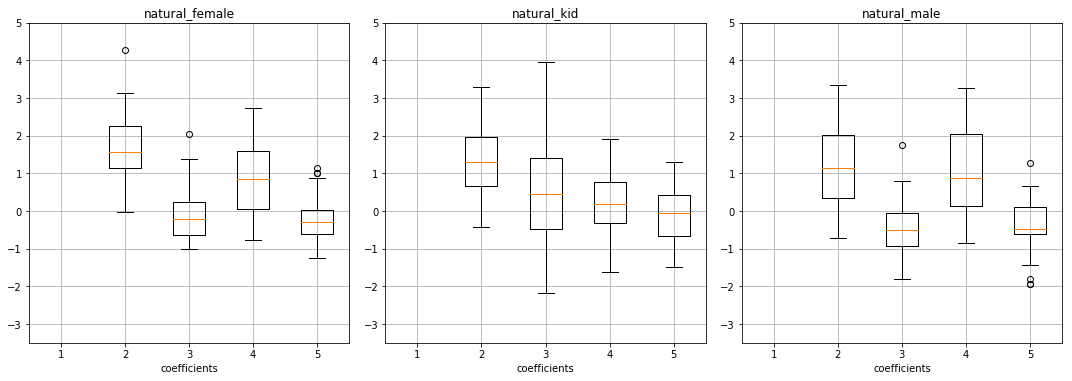

In [51]:
pl.figure(figsize=(15, 10))

NUM_PLOTS = len(FILES)
Y_MIN = -3.5
Y_MAX = 5
X_LABEL = 'coefficients'

for plot_index, s_class in enumerate(sorted(FILES.keys())):
    values = compute_mfcc(FILES[s_class], MFCC_COEFFS, 'mean')
    pl.subplot(2, 3, plot_index + 1)
    pl.ylim(Y_MIN, Y_MAX)
    pl.boxplot(values)
    pl.title(s_class)
    pl.xlabel(X_LABEL)
    pl.grid()
    
pl.tight_layout()

## MAN vs. WOMAN vs. KIS

Here we use only the natural voices of men and women to train a neural network that recognizes the gender of the speaker.

### Model complexity and learning duration

In order to choose the correct learning duration and the modely complexity, we iterate over the number of epochs (`EPOCHS`) and number of hidden neurons (`N_NEURONS`).

In [ ]:
N_INITS = 1
EPOCHS = 1500
#N_NEURONS = [2, 4] #, 8, 16, 32]
N_NEURONS = [32]
LEARNING_RATE = 0.001
MOMENTUM = 0.9

dataset = create_dataset([('natural_kid', -1), ('natural_female', 0), ('natural_kid', 1)], FILES, MFCC_COEFFS)
dataset_input = dataset[:, :-1]     # filter only input values (n-1 first values)
dataset_output = dataset[:, -1:]    # filter only the output class (last value)

MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))
for index, n_neurons in enumerate(N_NEURONS):
    print 'testing', n_neurons, 'neurons...'
    nn = MLP([MFCC_COEFFS, n_neurons, 1], 'logistic')

    for i in np.arange(N_INITS):
        nn.init_weights()
        MSE[index, i, :] = nn.fit((dataset_input, dataset_output),
                                  learning_rate=LEARNING_RATE,
                                  momentum=MOMENTUM,
                                  epochs=EPOCHS)

testing 32 neurons...


Then we plot the result :

In [ ]:
pl.figure(figsize=(15,4))

p_count = 0
colors = ['b', 'r', 'g']

for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)

    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')

    pl.ylim(0, 1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()

pl.tight_layout()

In [63]:
EPOCHS = 1000
N_NEURONS = [8, 16, 32]
K = 3

In [65]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS))
reload(cv)

dataset = create_dataset([('natural_kid', -1), ('natural_female', 1)], FILES)

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print 'Testing', h, 'neurons...'
    nn = MLP([MFCC_COEFFS, h, 1], 'tanh')
    temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,
                                                        dataset,
                                                        k=K,
                                                        learning_rate=LEARNING_RATE,
                                                        momentum=0,
                                                        epochs=EPOCHS)
    MSE_train[i_h, :] = temp1
    MSE_test[i_h, :] = temp2

Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


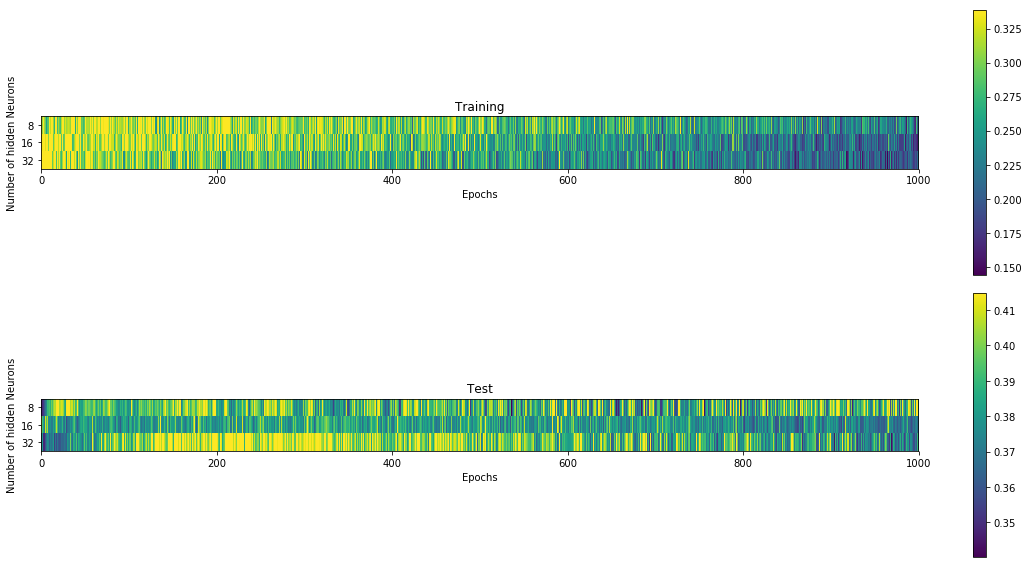

In [66]:
MAX_VAL = 90             # 100 is the maximum
pl.figure(figsize=(16, 8))
pl.subplot(2, 1, 1)
pl.imshow(MSE_train, vmin=np.min(MSE_train), vmax=np.percentile(MSE_train, 90), aspect=20, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2, 1, 2)
pl.imshow(MSE_test, vmin=np.min(MSE_test), vmax=np.percentile(MSE_test, 90), aspect=20, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

### Final Model and performance

In [ ]:
MOMENTUM = 0.5
EPOCHS = 10000
LEARNING_RATE = 0.001
N_NEURONS = 32

In [68]:
nn = MLP([MFCC_COEFFS, N_NEURONS, 1], 'tanh')
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                           dataset,
                                                           k=5,
                                                           learning_rate=LEARNING_RATE,
                                                           momentum=MOMENTUM,
                                                           epochs=EPOCHS,
                                                           threshold=0.0)

print 'MSE training: ', MSE_train
print 'MSE test: ', MSE_test
print 'Confusion matrix:'
pl.imshow(conf_mat)
pl.colorbar()
print conf_mat

KeyboardInterrupt: 